In [13]:
from sklearn.cluster import KMeans #Kmeans for clustering
import numpy as np #import essentials
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [237]:
C_Lambda = 0.03 #learning rate
TrainingPercent = 80 #training data percentage
ValidationPercent = 10 #validation data percentage
TestPercent = 10 #testing data percentage
M = 10 #number of clusters to be made
PHI = [] #phi matrix for computing the weights in closed form solution
IsSynthetic = False

In [238]:
def GetTargetVector(filePath): #method for fetching the target data from querlevelnorm_t.csv to a list
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[0]))
    #print("Raw Training Generated..")
    return t

def GenerateRawData(filePath, IsSynthetic):    #method for fetching the whole data from querylevelnorm_X.csv to a matrix
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row:
                dataRow.append(float(column)) #read each column in every row
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == False :
        dataMatrix = np.delete(dataMatrix, [5,6,7,8,9], axis=1) #deleting the columns or feature #5, 6, 7, 8, 9 since their values are zeroes
    dataMatrix = np.transpose(dataMatrix) #reading the data after swapping x & y axis since it makes easy to analyse the dataset    
    #print ("Data Matrix Generated..")
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80): #method for generating the target data
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))  
    print(TrainingLen)
    t           = rawTraining[:TrainingLen] #slicing 90% of  target data from raw data
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80): #method for generating training data from raw data matrix
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len] #slicing 90% of training data from raw data 
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): #method for generating validation data
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize 
    dataMatrix = rawData[:,TrainingCount+1:V_End] #slicing 5% validation data from raw data
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): #method for generating validation target data
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]#slicing 5% target data for validation
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):#method for generating big sigma in radial basis
    BigSigma    = np.zeros((len(Data),len(Data))) #initialize a 41x41 zeros matrix
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01)) #extracting number of samples for training       
    varVect     = []
    
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct)) #storing the variance of each feature in a list 
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j] #saving the variance diagonally in the bigsigma matrix
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)#scaling up the variance value
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv)) #formula for radial basis function. output is phi(x)
    return phi_x

def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80): #method for generating phi matrix
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))     #calcuing number of rows for training    
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) #initializing the phi matrix of 62661 x 10
    BigSigInv = np.linalg.inv(BigSigma) #calculating the inverse of bigsigma using np.linalg.in
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv) #storing the values of phi(x)
    #print ("PHI Generated..")
    return PHI

def GetWeightsClosedForm(PHI, T, Lambda): #method for calculating the weights
    Lambda_I = np.identity(len(PHI[0])) #identity matrix of length phi
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI) #phi^T
    PHI_SQR     = np.dot(PHI_T,PHI) #phi^T . phi
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR) #lambdaI + (phi^T . phi)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI) #(lambdaI + (phi^T . phi))^-1
    INTER       = np.dot(PHI_SQR_INV, PHI_T) #(lambdaI + (phi^T . phi))^-1 . phi^T
    W           = np.dot(INTER, T) #(lambdaI + (phi^T . phi))^-1 . phi^T . Training target data
    ##print ("Training Weights Generated..")
    return W

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

## Fetch and Prepare Dataset

In [239]:
RawTarget = GetTargetVector('Querylevelnorm_t.csv')
RawData   = GenerateRawData('Querylevelnorm_X.csv',IsSynthetic)

C:\Users\Shivam\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Shivam\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


## Prepare Training Data

In [240]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)

55699
(55699,)
(41, 55699)


## Prepare Validation Data

In [241]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Prepare Test Data

In [242]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(ValDataAct.shape)
print(ValData.shape)

(6962,)
(41, 6962)


## Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]

In [243]:
ErmsArr = []
AccuracyArr = []

kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))#Generating clusters using kmeans. A total of 10 clusters are created.
Mu = kmeans.cluster_centers_ #centroids of 10 clusters in an array
print(len(Mu))
GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

10


In [244]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 41)
(41, 41)
(55699, 10)
(10,)
(6962, 10)
(6961, 10)


## Finding Erms on training, validation and test set 

In [245]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget)) #accuracy on training data
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct)) #accuracy on validation data
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct)) #accuracy on test data
print(TestAccuracy)
print(TrainingAccuracy)

69.87501795719005,0.6279788453842932
73.92233253738846,0.5494694067137841


In [157]:
print ('UBITname      = shivammu')
print ('Person Number = 50289086')
print ('----------------------------------------------------')
print ("------------------LeToR Data------------------------")
print ('----------------------------------------------------')
print ("-------Closed Form with Radial Basis Function-------")
print ('----------------------------------------------------')
print ("M = 10 \nLambda = 0.9")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))

UBITname      = shivammu
Person Number = 50289086
----------------------------------------------------
------------------LeToR Data------------------------
----------------------------------------------------
-------Closed Form with Radial Basis Function-------
----------------------------------------------------
M = 10 
Lambda = 0.9
E_rms Training   = 0.5528324950745128
E_rms Validation = 0.5410872787323596
E_rms Testing    = 0.6311320276632623


## Gradient Descent solution for Linear Regression

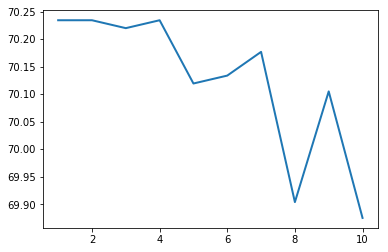

In [247]:
erms_data = [70.23416175836805, 70.23416175836805, 70.21979600632093, 70.23416175836805, 70.11923574199109, 70.13360149403822,
            70.17669875017957, 69.90374946128429, 70.10486998994398, 69.87501795719005] 
train_sam = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.plot(train_sam, erms_data, linewidth=2.0)
plt.tick_params(axis='y', labelsize=10)
plt.show()

In [13]:
W_Now        = np.dot(220, W)
La           = 2 #lambda
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,400):
    
    #print ('---------Iteration: ' + str(i) + '--------------')
    Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
    La_Delta_E_W  = np.dot(La,W_Now) #Lamda . delta_e_w
    Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
    Delta_W       = -np.dot(learningRate,Delta_E)
    W_T_Next      = W_Now + Delta_W #update weights 
    W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
    TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
    Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
    L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
    VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
    Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
    L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
    TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
    Erms_Test = GetErms(TEST_OUT,TestDataAct)
    L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [14]:
print ('----------Gradient Descent Solution--------------------')
print ("M = 15 \nLambda  = 0.0001\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

----------Gradient Descent Solution--------------------
M = 15 
Lambda  = 0.0001
eta=0.01
E_rms Training   = 0.54964
E_rms Validation = 0.53846
E_rms Testing    = 0.62372
